In [122]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg

In [123]:
gene = 'TP53'
results_dir = cfg.results_dir.joinpath('holdout_cancer_type/mutation/{}'.format(gene)).resolve()
stratified_results_dir = cfg.results_dir.joinpath('canonical_pathways/mutation/{}'.format(gene)).resolve()

In [124]:
results_df = None

for fname in os.listdir(results_dir):
    if 'classify' not in fname: continue
    if fname.startswith('.'): continue
    holdout_df = pd.read_csv(os.path.join(results_dir, fname), sep='\t')
    if results_df is None:
        results_df = holdout_df
    else:
        results_df = pd.concat((results_df, holdout_df), sort=False)
         
for fname in os.listdir(stratified_results_dir):
    if 'classify' not in fname or 'raw' not in fname: continue
    if fname.startswith('.'): continue
    raw_df = pd.read_csv(os.path.join(stratified_results_dir, fname), sep='\t')
    raw_df.rename(columns={'gene_or_cancertype': 'gene'}, inplace=True)
    results_df = pd.concat((raw_df, results_df), sort=False)
    
results_df = (
    results_df.fillna(value={'holdout_cancer_type': 'stratified'})
              .reset_index(drop=True)
              .drop(columns=['seed', 'algorithm', 'z_dim'])
)
results_df.head(n=20)

,auroc,aupr,gene,signal,data_type,holdout_cancer_type
0,0.92683,0.89873,TP53,signal,train,stratified
1,0.91468,0.87569,TP53,signal,test,stratified
2,0.91682,0.88206,TP53,signal,cv,stratified
3,0.67039,0.62539,TP53,shuffled,train,stratified
4,0.60173,0.55417,TP53,shuffled,test,stratified
5,0.56873,0.52888,TP53,shuffled,cv,stratified
6,0.92550,0.89140,TP53,signal,train,OV
7,0.47704,0.95087,TP53,signal,test,OV
8,0.91485,0.87360,TP53,signal,cv,OV
9,0.53614,0.52053,TP53,shuffled,train,OV


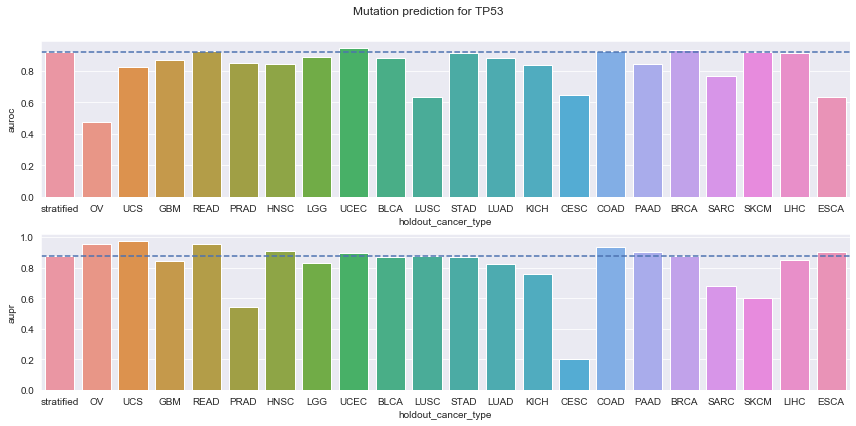

In [125]:
test_df = results_df[(results_df['data_type'] == 'test') & (results_df['signal'] == 'signal')]

sns.set({'figure.figsize': (12, 6)})
fig, axarr = plt.subplots(2, 1)

sns.barplot(data=test_df, x='holdout_cancer_type', y='auroc', ci=None, ax=axarr[0])
axarr[0].axhline(y=test_df[test_df['holdout_cancer_type'] == 'stratified']['auroc'].values[0], ls='--')
sns.barplot(data=test_df, x='holdout_cancer_type', y='aupr', ci=None, ax=axarr[1])
axarr[1].axhline(y=test_df[test_df['holdout_cancer_type'] == 'stratified']['aupr'].values[0], ls='--')
plt.tight_layout()
fig.suptitle('Mutation prediction for {}'.format(gene))
fig.subplots_adjust(top=0.9)

In [126]:
count_file = os.path.join(cfg.results_dir,
                          'canonical_pathways',
                          'mutation', gene,
                          '{}_filtered_cancertypes.tsv'.format(gene))
count_df = (
    pd.read_csv(count_file, sep='\t')
      .set_index(keys='DISEASE')
)
count_df

,status_count,status_proportion,disease_included
DISEASE,,,
ACC,15,0.197368,False
BLCA,201,0.505025,True
BRCA,349,0.355759,True
CESC,25,0.091912,True
CHOL,4,0.111111,False
COAD,198,0.580645,True
DLBC,5,0.135135,False
ESCA,149,0.881657,True
GBM,45,0.362903,True


In [127]:
# TODO: think about how to get count/proportion for stratified holdout set,
# this might be an interesting comparison
join_df = test_df.join(count_df, on='holdout_cancer_type', how='left')
plot_df = join_df[join_df['status_count'].notna()]

Text(0, 0.5, 'AUROC')

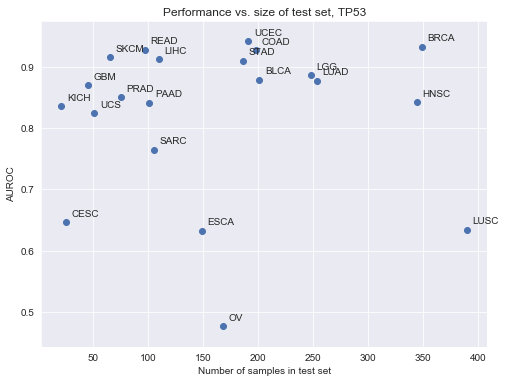

In [128]:
sns.set({'figure.figsize': (8, 6)})
plt.scatter(x=plot_df['status_count'].values, y=plot_df['auroc'].values)
for i, txt in enumerate(plot_df['holdout_cancer_type'].values):
    plt.annotate(txt, (plot_df['status_count'].values[i]+5, plot_df['auroc'].values[i]+0.01))
plt.title('Performance vs. size of test set, {}'.format(gene))
plt.xlabel('Number of samples in test set')
plt.ylabel('AUROC')

Text(0, 0.5, 'AUROC')

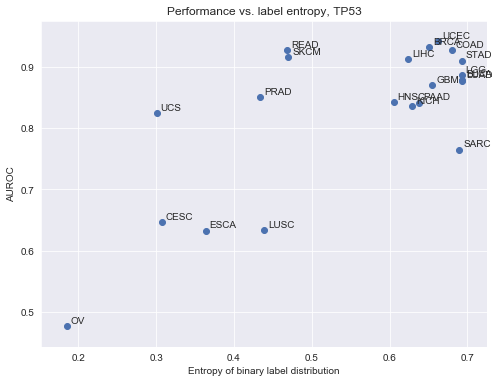

In [129]:
from scipy.stats import entropy

p = plot_df['status_proportion'].values
q = 1 - p
entropy_vals = [entropy(vs) for vs in zip(p, q)]

sns.set({'figure.figsize': (8, 6)})
plt.scatter(x=entropy_vals, y=plot_df['auroc'].values)
for i, txt in enumerate(plot_df['holdout_cancer_type'].values):
    plt.annotate(txt, (entropy_vals[i]+0.005, plot_df['auroc'].values[i]+0.005))
plt.title('Performance vs. label entropy, {}'.format(gene))
plt.xlabel('Entropy of binary label distribution')
plt.ylabel('AUROC')